In [2]:
# Import libraries

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras import layers

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import pandas as pd
import numpy as np

import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet

Using TensorFlow backend.


In [3]:
# Setup

EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 500
VALIDATION_SPLIT = 0.3
BATCH_SIZE = 1000
MAX_NB_WORDS = 30000

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# Get data from file

df = pd.read_csv("enron_email_dataset.csv")
df.describe()

role                                            content  \
count     340020                                             340020   
unique         7                                              71185   
top     Employee  Welcome to Enron Center South. As you have pro...   
freq      113598                                               2539   

                       Date                                        From  \
count                340020                                      340020   
unique                71784                                        9210   
top     2001-11-19 01:56:21  frozenset({'veronica.espinoza@enron.com'})   
freq                   2537                                       12267   

                                 To                              Subject  
count                        340020                               332213  
unique                          138                                54677  
top     'richard.shapiro@enron.com'  Enron Center South Technology Watch  
freq                          14648                                 2542

In [5]:
# Basic data cleaning

msgList=list()
lines=df['content'].values.tolist()
labels=df['role'].values.tolist()
for line in lines:
    tokens=word_tokenize(line)
    tokens=[w.lower()for w in tokens]
    table=str.maketrans("","",string.punctuation)
    stripped=[w.translate(table) for w in tokens]
    words=[word for word in stripped if word.isalpha()]
    stop_words=set(stopwords.words('english'))
    words=[w for w in words if not w in stop_words]
    msgList.append(words)
    
print(len(msgList),len(labels))

340020 340020


In [6]:
msglist = list()
for msg in msgList:
    txt = ""
    for word in msg:
        txt += word + " "
    msglist.append(txt)

dataList = []
dataList.append(labels)
dataList.append(msglist)

data_df = pd.DataFrame(dataList)
data_df.describe()

0      1                                                  2       \
count         2      2                                                  2   
unique        2      2                                                  2   
top     Manager  trip   attached please find key contact list energy o...   
freq          1      1                                                  1   

       3         4                                                  5       \
count       2         2                                                  2   
unique      2         2                                                  2   
top       CEO  Employee  designated member resource pur poses enron who...   
freq        1         1                                                  1   

                                                   6       \
count                                                   2   
unique                                                  2   
top     chinese wall training one hour scheduled dates...   
freq                                                    1   

                                                   7       \
count                                                   2   
unique                                                  2   
top     chinese wall training one hour scheduled dates...   
freq                                                    1   

                                                   8      9       ...  \
count                                                   2      2  ...   
unique                                                  2      2  ...   
top     chinese wall training one hour scheduled dates...    CEO  ...   
freq                                                    1      1  ...   

                340010                                             340011  \
count                2                                                  2   
unique               2                                                  2   
top     Vice President  hotwebcash find match could click aol users cl...   
freq                 1                                                  1   

                                                   340012  \
count                                                   2   
unique                                                  2   
top     hotwebcash turned receiving loan bank poor cre...   
freq                                                    1   

                                                   340013  \
count                                                   2   
unique                                                  2   
top     sincerely new offers staff email sent hotwebca...   
freq                                                    1   

                                                   340014    340015  \
count                                                   2         2   
unique                                                  2         2   
top     seeing message email client support html pleas...  Director   
freq                                                    1         1   

                340016                                             340017  \
count                2                                                  2   
unique               2                                                  2   
top     Vice President  feb dec trades feb dec went bid heard elswhere...   
freq                 1                                                  1   

                                                   340018          340019  
count                                                   2               2  
unique                                                  2               2  
top     bom traded feb traded away traded feb dec trad...  Vice President  
freq                                                    1               1  

[4 rows x 340020 columns]

In [7]:
data_df = data_df.T
data_df.describe()

0                                                  1
count     340020                                             340020
unique         7                                              68236
top     Employee  received executed eei master power purchase sa...
freq      113598                                               2660

In [8]:
data_df = data_df.rename(columns={0: "role", 1: "msg"})
data_df.to_csv("dataset.csv", encoding='utf-8', index=False)

# Run from here

In [4]:
df = pd.read_csv("dataset.csv")
df = df.dropna(subset=['msg', 'role'])
df.describe()

role                                                msg
count     339551                                             339551
unique         7                                              68235
top     Employee  received executed eei master power purchase sa...
freq      113490                                               2660

In [5]:
lines=df['msg'].values.tolist()
labels=df['role'].values.tolist()
review_lines = list()
for line in lines:
    review_lines.append(str(line).split())
review_lines[0]

['chinese',
 'wall',
 'training',
 'one',
 'hour',
 'scheduled',
 'dates',
 'training',
 'mandatory',
 'allows',
 'ews',
 'continue',
 'operating',
 'businesses',
 'including',
 'equity',
 'trading',
 'without',
 'violating',
 'securities',
 'la',
 'ws',
 'please',
 'register',
 'one',
 'four',
 'onehour',
 'sessions',
 'listed',
 'session',
 'tailored',
 'particular',
 'commercial',
 'group',
 'would',
 'preferable',
 'could',
 'attend',
 'session',
 'group',
 'particula',
 'group',
 'one',
 'highlighted',
 'bold',
 'list',
 'monday',
 'march',
 'resource',
 'group',
 'monday',
 'march',
 'originationbusiness',
 'development',
 'monday',
 'march',
 'pm',
 'financial',
 'trading',
 'group',
 'monday',
 'march',
 'pm',
 'heads',
 'trading',
 'desks',
 'sessions',
 'held',
 'downtown',
 'hyatt',
 'regency',
 'hotel',
 'sandalwood',
 'rooms',
 'b',
 'alternatively',
 'two',
 'makeup',
 'sessions',
 'schedul',
 'tuesday',
 'march',
 'pm',
 'pm',
 'location',
 'informatio',
 'makeup',
 'ses

In [6]:
# import gensim

# model=gensim.models.Word2Vec(sentences=review_lines,size=EMBEDDING_DIM,window=5,workers=4,min_count=1)
# words=list(model.wv.vocab)
# model.wv.save_word2vec_format("msg_embedding_word2vec_multiple_receivers.txt",binary=False)
# print(len(words))

In [7]:
import os
embeddings_index={}
f=open(os.path.join('','msg_embedding_word2vec_multiple_receivers.txt'),encoding='utf-8')
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embeddings_index[word]=coefs
f.close


<function TextIOWrapper.close()>

In [8]:
labelInt = {'CEO': 0,
 'Director': 1,
 'Employee': 2,
 'Manager': 3,
 'President': 4,
 'Trader': 5,
 'Vice President': 6}

labelsInt = list()
for txt in labels:
    labelsInt.append(labelInt[txt])
labelsInt[:6]

[3, 4, 4, 0, 2, 4]

In [9]:
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(review_lines)
sequences=tokenizer_obj.texts_to_sequences(review_lines)

word_index=tokenizer_obj.word_index

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(len(data))
print(data[1])

encodeLabels = to_categorical(np.asarray(labelsInt))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', encodeLabels.shape)

339551
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0

## Try with ANN

In [10]:
# create a model
model = tf.keras.Sequential()

# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(500, activation='sigmoid',input_shape=(MAX_SEQUENCE_LENGTH,)))
# Add another:
model.add(layers.Dense(500, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.1)))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(7, activation='softmax'))

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.MeanSquaredError(), #CategoricalCrossentropy
              metrics=METRICS)
model.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               250500    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 551,807
Trainable params: 551,807
Non-trainable params: 0
_________________________________________________________________


In [12]:
# train model
history = model.fit(data, encodeLabels, epochs=20, validation_split=0.4, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')])

Epoch 1/20
6367/6367 [==============================] - 40s 6ms/step - loss: 9.9671 - tp: 0.0000e+00 - fp: 2.0000 - tn: 1222378.0000 - fn: 203730.0000 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7359 - val_loss: 9.3687 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 814926.0000 - val_fn: 135821.0000 - val_accuracy: 0.8572 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6958
Epoch 2/20
6367/6367 [==============================] - 38s 6ms/step - loss: 9.6047 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1222380.0000 - fn: 203730.0000 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7365 - val_loss: 9.7564 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 814926.0000 - val_fn: 135821.0000 - val_accuracy: 0.8572 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6880
Epoch 3/20
6367/6367 [==============================] - 38s 6ms/step - loss: 9.6012 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1222380.0000 - f

In [13]:
figName = "Word2vec ANN_ consider multiple recevers"

metrics =  ['accuracy', 'loss', 'precision', 'recall']
fig = plt.figure()
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], 'b', linestyle="--", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], 'r', label='Val',linewidth=2.0)
    plt.xlabel('Epoch',fontsize = 14)
    plt.ylabel(name, fontsize = 16)
    if metric == 'precision' or metric == 'recall':
      plt.ylim([0.0,1])
    else:
        plt.ylim([plt.ylim()[0], plt.ylim()[1]])

    plt.legend()
fig.suptitle(figName,fontsize=20)
fig.savefig(figName+'.png')

## Try ANN with weight

In [14]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(labels),labels)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 2.6316886780753967,
 1: 1.5797845860376394,
 2: 0.4274146243218408,
 3: 1.3423906382810493,
 4: 2.2752010184937013,
 5: 2.140845869639232,
 6: 0.5010513858372057}

In [15]:
# create a model
model = tf.keras.Sequential()

# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(500, activation='sigmoid',input_shape=(MAX_SEQUENCE_LENGTH,)))
# Add another:
model.add(layers.Dense(500, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.1)))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(7, activation='softmax'))

In [16]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.MeanSquaredError(), #CategoricalCrossentropy
              metrics=METRICS)
model.summary();

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_6 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 707       
Total params: 551,807
Trainable params: 551,807
Non-trainable params: 0
_________________________________________________________________


In [17]:
# train model
history = model.fit(data, encodeLabels, epochs=20, class_weight=class_weights, validation_split=0.4, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')])

Epoch 1/20
6367/6367 [==============================] - 39s 6ms/step - loss: 10.1284 - tp: 1.0000 - fp: 2.0000 - tn: 1222378.0000 - fn: 203729.0000 - accuracy: 0.8571 - precision: 0.3333 - recall: 4.9085e-06 - auc: 0.6434 - val_loss: 9.4856 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 814926.0000 - val_fn: 135821.0000 - val_accuracy: 0.8572 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5712
Epoch 2/20
6367/6367 [==============================] - 39s 6ms/step - loss: 9.7877 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1222380.0000 - fn: 203730.0000 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6417 - val_loss: 9.9275 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 814926.0000 - val_fn: 135821.0000 - val_accuracy: 0.8572 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6203
Epoch 3/20
6367/6367 [==============================] - 36s 6ms/step - loss: 9.7852 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1222380.0000 - fn: 2037

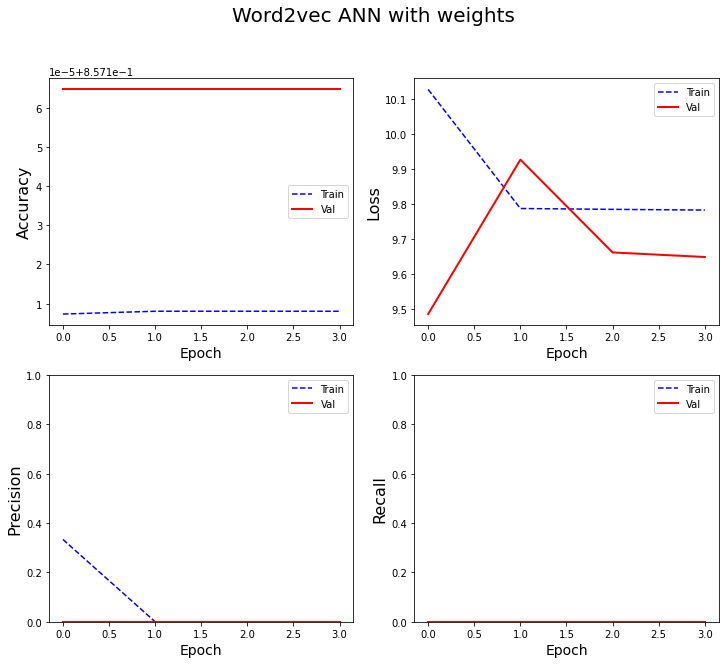

In [18]:
figName = "Word2vec ANN with weights"

metrics =  ['accuracy', 'loss', 'precision', 'recall']
fig = plt.figure()
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], 'b', linestyle="--", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], 'r', label='Val',linewidth=2.0)
    plt.xlabel('Epoch',fontsize = 14)
    plt.ylabel(name, fontsize = 16)
    if metric == 'precision' or metric == 'recall':
      plt.ylim([0.0,1])
    else:
        plt.ylim([plt.ylim()[0], plt.ylim()[1]])

    plt.legend()
fig.suptitle(figName,fontsize=20)
fig.savefig(figName+'.png')